In [42]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import datetime
import os
warnings.filterwarnings("ignore")

def tsplot(y, lags=50, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

def write_results(file_name, results, columns):
    with open(file_name,"w") as fw:
        print(results.summary(), file=fw)
        fw.write("================test_whiteness================\n")
        print(results.test_whiteness(nlags=20), file=fw)
        fw.write("================results.roots()================\n")
        for root in results.roots:
            fw.write(str(root)+",")
        fw.write("\n================is_stable================\n")
        fw.write(str(results.is_stable()))
        fw.write("\n================granger causality================\n")
        for V1 in columns:
            for V2 in columns:
                fw.write("Granger test: "+V2+"-->"+V1+"\n")
                print(results.test_causality(V1, [V2],kind='f').summary(), file=fw)
                fw.write("\n")

        fw.write("\n================long_run effects================\n")
        for effect in results.long_run_effects():
            fw.write(str(effect)+",")
        fw.write("\n================FEVD values================\n")
        from contextlib import redirect_stdout
        with redirect_stdout(fw):
            print(results.fevd(20).summary())

def structural_analyses(file_name, results, lag=20):
    # impulse response analyses
    irf = results.irf(lag)
    irf.plot(orth=False)
    plt.savefig(file_name+"_irf_noorth.png")
    # irf.plot(impulse='V1', response="V2")
    irf.plot_cum_effects(orth=False)
    plt.savefig(file_name+"_irf_cum_noorth.png")
    results.long_run_effects()

    # forecast error decomposition
    results.fevd(lag).plot()
    plt.savefig(file_name+"_fevd.png")
    

In [43]:
# read csv file    
df = pd.read_csv("data.csv")
# convert to date format
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d").dt.date

# drop first 6 rows to be able to divide by 7 (starts on Sunday)
df = df.iloc[6:]
df.index = pd.to_datetime(df['date'])
df.drop(['Unnamed: 0', 'date'], axis=1, inplace=True)
df = df.resample('7D').mean()

# set date as index
print(df)

                   USD           BTC          ETH       XLM      USDT  \
date                                                                    
2017-04-09  100.767141   1184.245728    46.184528  0.002989  0.999690   
2017-04-16   99.977143   1211.664289    48.926500  0.003559  0.988751   
2017-04-23   99.147144   1279.989990    57.405158  0.004069  0.924279   
2017-04-30   98.920001   1483.474278    85.927657  0.008408  0.944119   
2017-05-07   99.311429   1748.609985    90.783716  0.036769  0.974597   
...                ...           ...          ...       ...       ...   
2021-02-28   91.328572  48583.871094  1539.878488  0.414477  1.000721   
2021-03-07   91.831428  55809.454241  1821.154227  0.410833  1.000388   
2021-03-14   91.781429  57914.933036  1812.828805  0.398707  1.000728   
2021-03-21   92.429998  54625.823104  1680.901507  0.386942  1.001204   
2021-03-28   93.030573  58496.472097  1927.556728  0.421905  1.000511   

                NANO  
date                  
2017

                   USD           BTC      NANO
date                                          
2017-04-09  100.767141   1184.245728  0.009569
2017-04-16   99.977143   1211.664289  0.009025
2017-04-23   99.147144   1279.989990  0.011387
2017-04-30   98.920001   1483.474278  0.015687
2017-05-07   99.311429   1748.609985  0.014796
...                ...           ...       ...
2021-02-28   91.328572  48583.871094  5.169027
2021-03-07   91.831428  55809.454241  5.493371
2021-03-14   91.781429  57914.933036  5.051486
2021-03-21   92.429998  54625.823104  4.615602
2021-03-28   93.030573  58496.472097  5.024524

[208 rows x 3 columns]


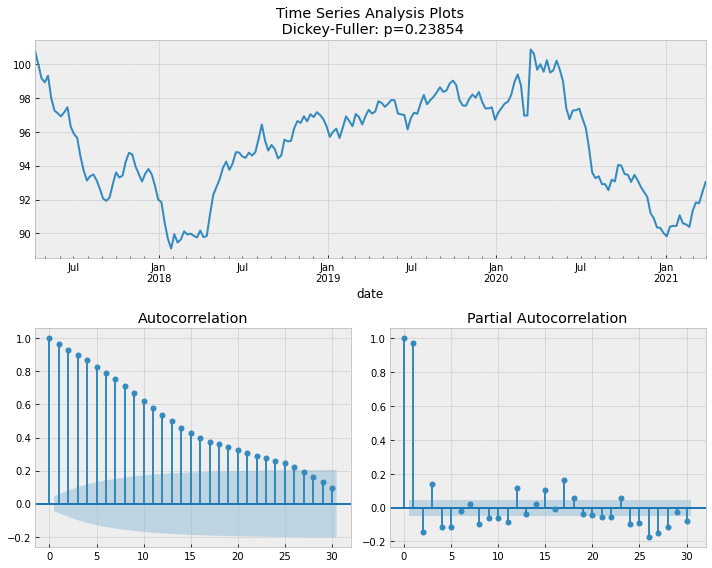

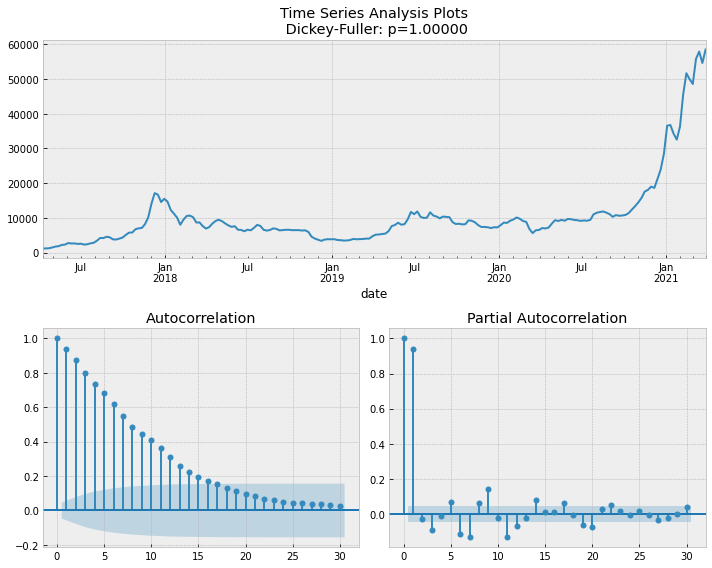

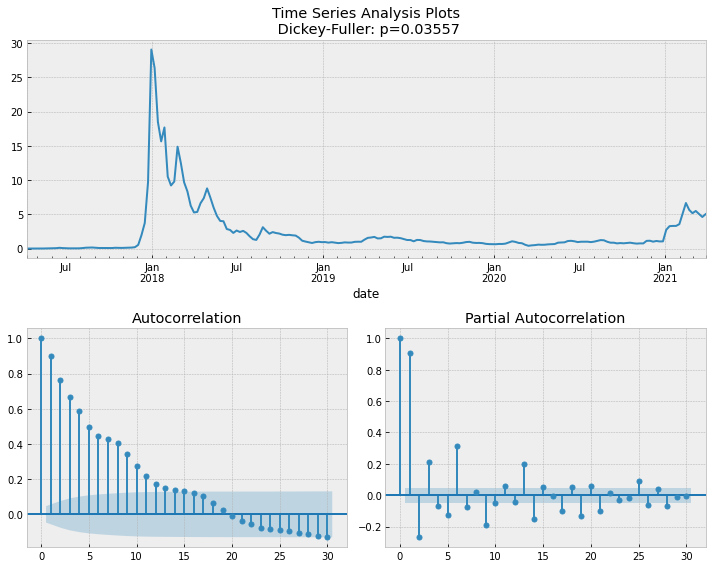

In [44]:
# Nano Case
id = 'nano_weekly'
data = df.drop(['USDT', 'ETH','XLM'], axis=1, inplace = False)
print(data)

focused_columns = ["USD", "BTC", "NANO"]

if not os.path.exists(id):
    os.makedirs(id)

# see original plots of all products
for column in focused_columns:
    tsplot(data[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_'+column+'.png')
    plt.show()
    plt.close()

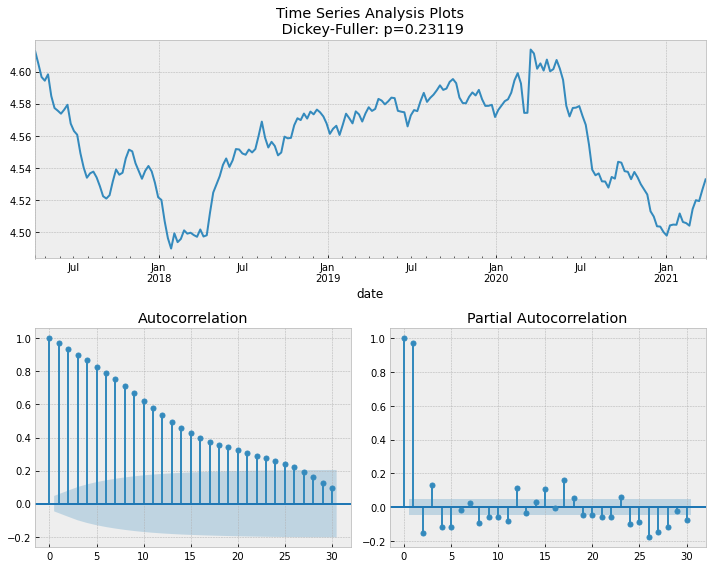

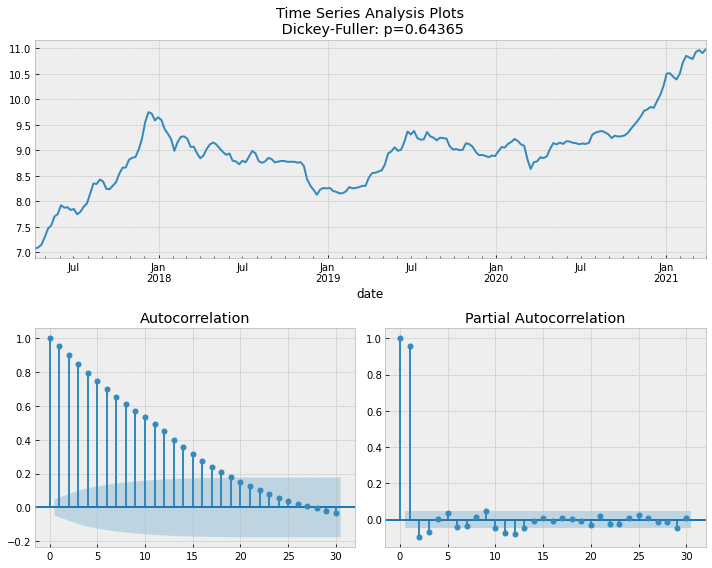

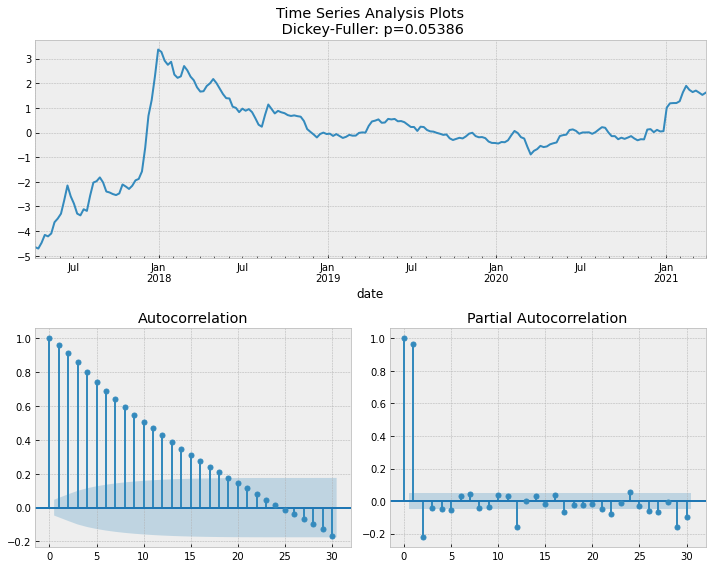

In [45]:
# log transformation
data_log = data.copy()
for column in focused_columns:
    data_log[column] = np.log(data[column]) 
    tsplot(data_log[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_log_'+column+'.png')
    plt.show()
    plt.close()


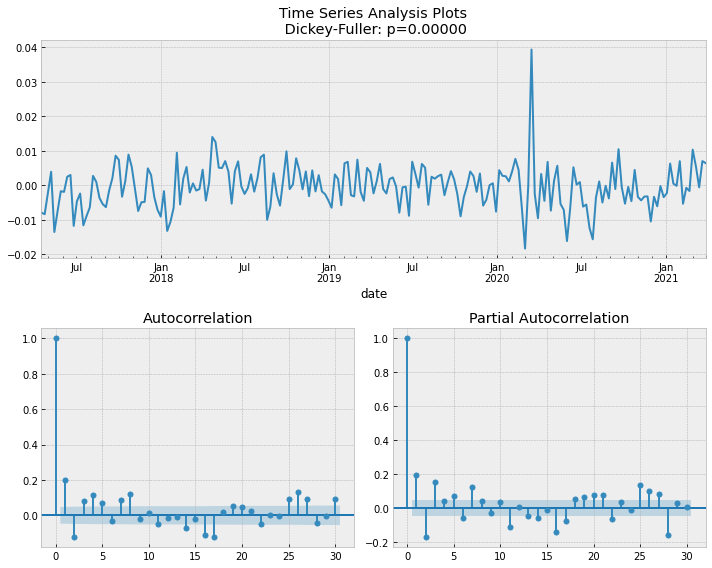

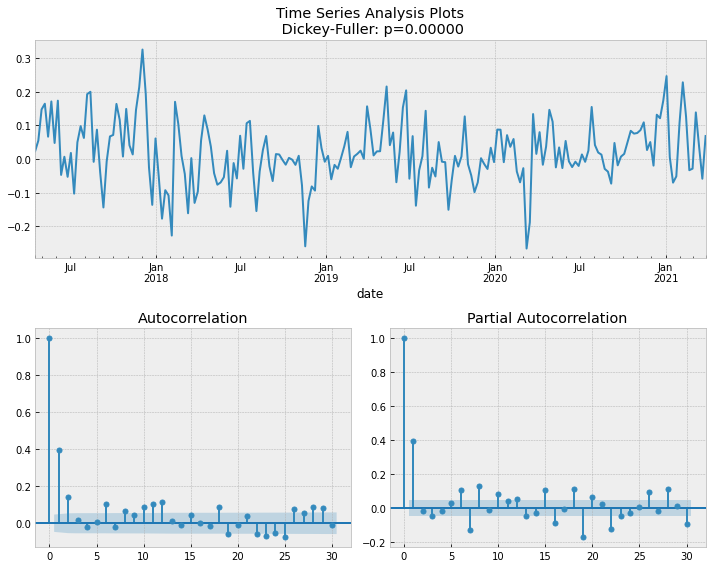

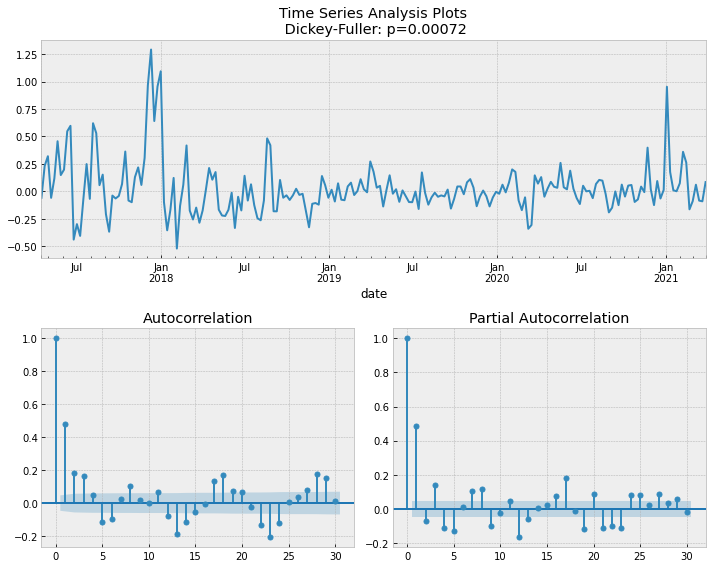

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.16      -18.11   1.293e-08      -18.14
1       -18.68     -18.47*   7.753e-09      -18.59
2      -18.75*      -18.39  7.177e-09*     -18.61*
3       -18.75      -18.23   7.194e-09      -18.54
4       -18.71      -18.04   7.497e-09      -18.44
5       -18.68      -17.85   7.724e-09      -18.34
6       -18.63      -17.65   8.097e-09      -18.23
7       -18.60      -17.46   8.385e-09      -18.14
8       -18.58      -17.28   8.596e-09      -18.05
9       -18.54      -17.09   8.966e-09      -17.95
10      -18.49      -16.88   9.419e-09      -17.84
11      -18.43      -16.67   1.002e-08      -17.72
12      -18.42      -16.51   1.013e-08      -17.65
13      -18.40      -16.32   1.044e-08      -17.56
14      -18.34      -16.11   1.112e-08      -17.44
15      -18.31      -15.93   1.152e-08      -17.34
16      -18.26      -15.72   1.

In [46]:
# first order differencing
data_diff = data_log.diff().dropna()
for column in focused_columns:
    tsplot(data_diff[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_diff_'+column+'.png')
    plt.show()
    plt.close()

# modelling using VAR for analysis
model = VAR(data_diff.dropna())
print(model.select_order(20).summary())
selected_orders = model.select_order(20).selected_orders
print(selected_orders)

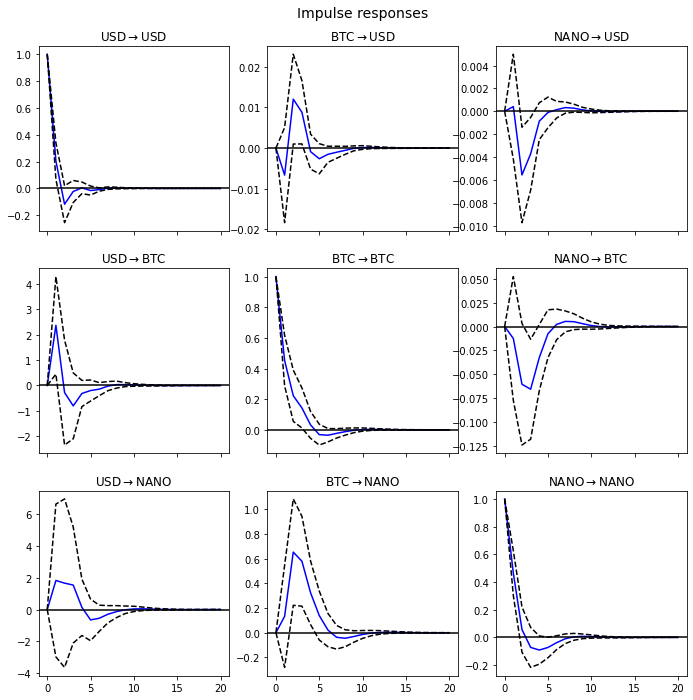

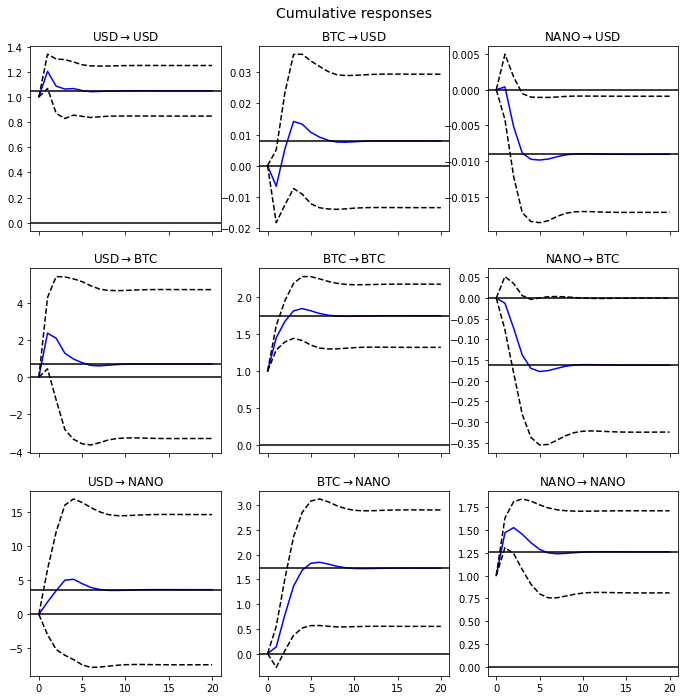

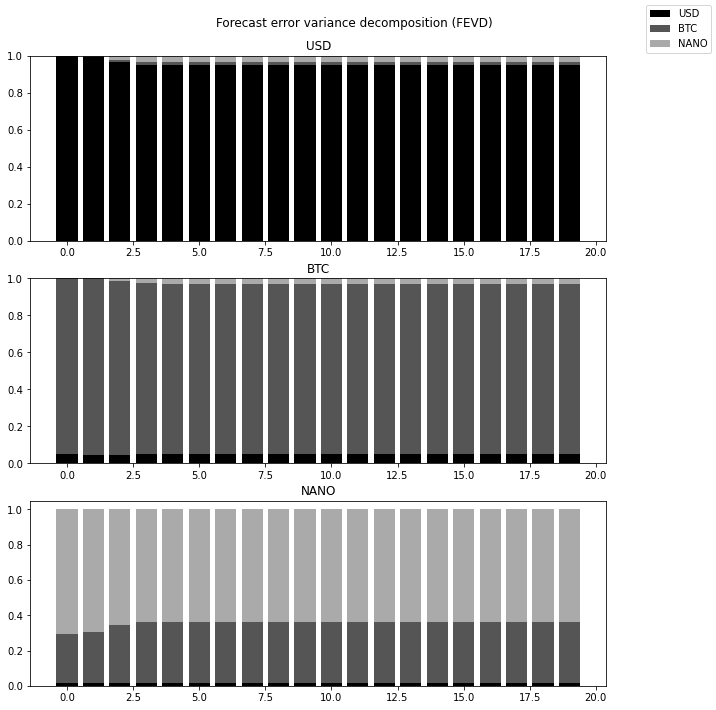

In [72]:
# order 2 is the best lag order
order = 2
results = model.fit(order, trend="c")
results_file = f"{id}/results_lag{order}.txt" 
structural_file = f"{id}/lag{order}"
columns = data.columns.values.tolist()
write_results(results_file, results, columns)
structural_analyses(structural_file, results, 20)